In [4]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1) to sys.path


In [11]:
from random_forest_classifier_2a import RandomForestMoodModel, plot_predicted_vs_actual
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from data_loading import DataPreprocessor
from random_forest_classifier_2a import split_train_val_per_id,plot_rf_predictions, train_random_forest

In [6]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, for_RNN_model=False)

Removed 53 outliers from 1268 observations. Percentage: 4.18%


In [26]:
# fit 1 model for all users

# 1. Prepare features and labels, filtering rare classes
label_counts = train_df['mood'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df_filtered = train_df[train_df['mood'].isin(valid_labels)]

# Keep date column for evaluation
dates = train_df_filtered['date']

# Then drop id, mood, and date for features
features = train_df_filtered.drop(columns=['id', 'mood', 'date'])
labels = train_df_filtered['mood']

# 2. Use split_train_val_per_id to split data
train_user_df, val_user_df = split_train_val_per_id(train_df_filtered, val_frac=0.2)

# Prepare training and validation data for the model
X_train = train_user_df.drop(columns=["id", "mood", "date"])
y_train = train_user_df["mood"]
X_val = val_user_df.drop(columns=["id", "mood", "date"])
y_val = val_user_df["mood"]

# Also save dates for validation set for evaluation
dates_val = val_user_df['date']

# 3. Train the classifier with class weights
#best_params =  grid_search.best_params_
model = RandomForestMoodModel(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)

# 4. Evaluate on validation set
val_preds = model.predict(X_val)
print("\nValidation Report:")
print(classification_report(y_val, val_preds))

# 5. Evaluate daily average performance
rmse, mean_error = model.evaluate_daily_average_performance(y_val, val_preds, dates_val)
print("Daily average RMSE:", rmse)
print("Mean Error:", mean_error)

# 6. Predict on test set
X_test = test_df.drop(columns=['id', 'mood', 'date'])
test_preds = model.predict(X_test)

# 7. Attach predictions
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_preds

# 8. Output predictions
print(test_df_with_preds[['id', 'predicted_mood_class']])



Validation Report:
              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00        13
          12       0.40      0.08      0.13        25
          13       0.38      0.11      0.17        28
          14       0.41      0.90      0.56       102
          15       0.18      0.06      0.09        34
          16       0.50      0.03      0.05        38
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         3

    accuracy                           0.40       250
   macro avg       0.19      0.12      0.10       250
weighted avg       0.35      0.40      0.28       250

Daily average RMSE: 1.155661825899958
Mean Error: -0.2763623615267214
         id  predicted_mood_class
0   AS14.01                    14
1   AS14.02                    14
2   AS14.03                    14
3   AS14.05    

/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

In [ ]:
# Grid search for parameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier(random_state=42)

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, max_features=sqrt

In [ ]:
# fit 1 model per user

test_predictions = []
train_predictions = []
test_actuals = []
train_actuals = []
final_predictions = []
user_ids = []

# 1. Prepare features and labels, filtering rare classes
label_counts = train_df['mood'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df_filtered = train_df[train_df['mood'].isin(valid_labels)]

# Keep date column for evaluation
dates = train_df_filtered['date']

# Then drop id, mood, and date for features
features = train_df_filtered.drop(columns=['id', 'mood', 'date'])
labels = train_df_filtered['mood']

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]
    
    train_user_df, test_user_df = split_train_val_per_id(train_group, val_frac=0.2)

    X_train = train_user_df.drop(columns=["id", "mood", "date"])
    y_train = train_user_df["mood"]
    X_test = test_user_df.drop(columns=["id", "mood", "date"])
    y_test = test_user_df["mood"]


    best_params =  grid_search.best_params_
    model = RandomForestMoodModel(class_weight='balanced', random_state=42, **best_params)
    
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    train_predictions.extend(train_preds)
    train_actuals.extend(y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = test_df[test_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)


Training Data - MAPE: 0.00%, MAE: 0.00, MSE: 0.00, R_squared: 1.00
Test Data - MAPE: 7.89%, MAE: 1.05, MSE: 2.60, R_squared: -0.08


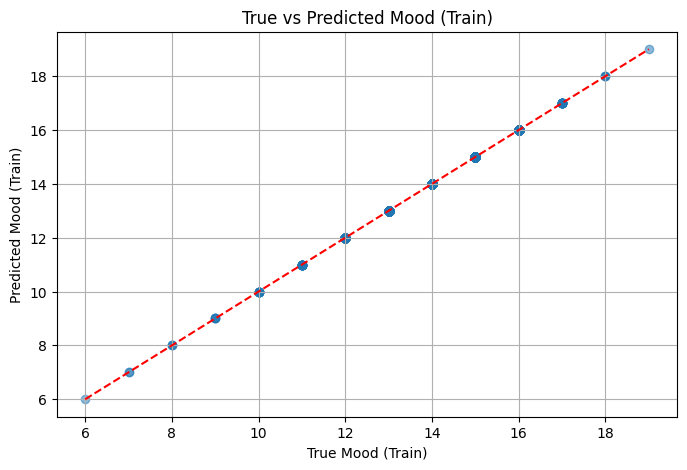

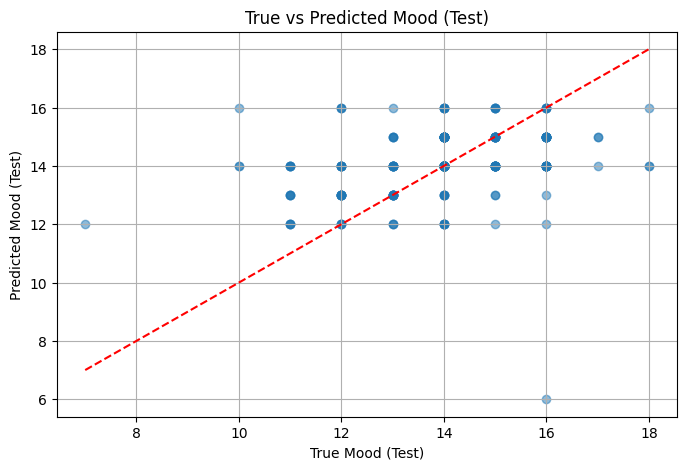

In [23]:
plot_rf_predictions(train_actuals, train_predictions, test_actuals, test_predictions)